# Experimental Results 

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# 1 Basic Retrieval (Blocking I/O)

This was for the blocking I/O version of the project, but it is now deprecated.

In [2]:
BLOCKING_IO = False

In [3]:
if BLOCKING_IO:
    retrieval_df = pd.read_csv("retrieval.benchmark")
    retrieval_df = retrieval_df[~retrieval_df.key.isin(["START", "END"])]
    retrieval_df.head()

In [4]:
if BLOCKING_IO:
    plt.rcParams.update({'font.size': 18})
    plt.plot(retrieval_df.operation_sequence_number, retrieval_df.read_time, "-o")
    plt.title("Total Read Time for $n$ Operations")
    plt.xlabel("Operation Sequence Number")
    plt.ylabel("Read Time (s)")
    plt.show()

# 2 Concurrent Retrieval (Non-blocking I/O)

In [5]:
n_clients = [1, 2, 5, 10, 20, 50, 100]

df_pieces = []

for n in n_clients:
    folder = f"concurrent_{n}"
    for f in os.scandir(folder):
        client_i = f.path.split("_")[-1].split(".")[0]
        df_piece = pd.read_csv(f.path)
        df_piece["n_clients"] = n
        df_piece["client_i"] = client_i
        df_pieces.append(df_piece)

concurrent_df = pd.concat(df_pieces, axis=0)
concurrent_df.head()

,key,operation_sequence_number,read_time,event_time,n_clients,client_i
0,START,0,-1,1720460311,1,1
1,END,10000,-1,1720460645,1,1
0,START,0,-1,1720461048,2,1
1,END,5000,-1,1720461179,2,1
0,START,0,-1,1720461048,2,2


In [6]:
start_df = concurrent_df[concurrent_df.key == "START"].groupby(by=["n_clients"]).event_time.min().to_frame()
start_df

,event_time
n_clients,
1,1720460311
2,1720461048
5,1720461261
10,1720461385
20,1720461490
50,1720462168
100,1720462013


In [7]:
end_df = concurrent_df[concurrent_df.key == "END"].groupby(by=["n_clients"]).event_time.max().to_frame()
end_df

,event_time
n_clients,
1,1720460645
2,1720461179
5,1720461311
10,1720461409
20,1720461515
50,1720462203
100,1720462096


In [8]:
duration_df = end_df - start_df
duration_df = duration_df.rename(columns={"event_time" : "duration_s"})
duration_df.reset_index(inplace=True)
duration_df

,n_clients,duration_s
0,1,334
1,2,131
2,5,50
3,10,24
4,20,25
5,50,35
6,100,83


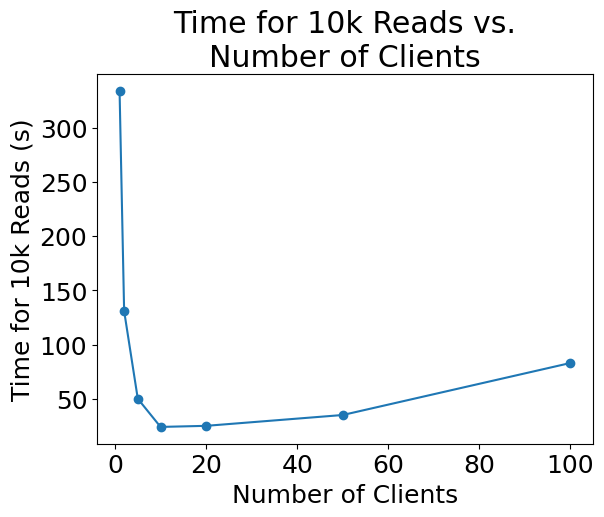

In [9]:
plt.rcParams.update({'font.size': 18})
plt.plot(duration_df.n_clients, duration_df.duration_s, "-o")
plt.title("Time for 10k Reads vs.\nNumber of Clients")
plt.xlabel("Number of Clients")
plt.ylabel("Time for 10k Reads (s)")
plt.show()